# *MACHINE LEARNING, ARTIFICIAL NEURAL NETWORKS AND DEEP LEARNING pt. 2*
Exam Session 19 June 2025

By Claudia Maria Carboni (Matricola: 535421)

## **1. Model Choice**

Since the task is to predict both a binary label (good/bad review) and a continuous score for each hotel review, I need a model that can deal with both types of outputs at the same time and make the most of the data available.

- For the text part, I use an LSTM, because LSTMs are great at picking up sentiment, structure, and patterns in sequences of words.  
- For the numerical features, I go with a standard MLP, which works well for tabular data and can quickly learn simple patterns.

I combine these two approaches so the model can learn from both the text and numbers together, which feels like the most natural way to tackle this problem, since both types of information matter for how people rate and describe hotels.


### **1.a Data Loading**

I load the data directly from a public repository so that the notebook is fully reproducible without any manual intervention. This way, everything can be executed as required by the exam guidelines.


In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Libraries from Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
# Libraries from Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## **2. Initial Data Exploration and Preprocessing**

First, I quickly check the main statistics and class distribution to get a sense of the data and make sure nothing is off.  
For preprocessing, I extract only the year from the review date (to keep things simple), encode the review type as binary (Good = 1, Bad = 0), and clean the review text (lowercase, remove punctuation, numbers, stopwords).  
I also combine the review text with the hotel name into a single field because sometimes the hotel name itself carries a signal about the review, and it helps the model context.


In [5]:
url = 'https://raw.githubusercontent.com/claucoals/deep_learning/main/input_data.csv'
df = pd.read_csv(url)
df.columns

Index(['Hotel_Address', 'Review_Date', 'Average_Score', 'Hotel_Name',
       'Reviewer_Nationality', 'Hotel_number_reviews',
       'Reviewer_number_reviews', 'Review_Score', 'Review', 'Review_Type'],
      dtype='object')

In [6]:
df.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


In [7]:
print(f"dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

dataset shape: 13772 rows, 10 columns


In [8]:
print("columns names:")
df.columns.tolist()

columns names:


['Hotel_Address',
 'Review_Date',
 'Average_Score',
 'Hotel_Name',
 'Reviewer_Nationality',
 'Hotel_number_reviews',
 'Reviewer_number_reviews',
 'Review_Score',
 'Review',
 'Review_Type']

In [9]:
print("information on the dataset:")
df.info()

information on the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            13772 non-null  object 
 1   Review_Date              13772 non-null  object 
 2   Average_Score            13772 non-null  float64
 3   Hotel_Name               13772 non-null  object 
 4   Reviewer_Nationality     13772 non-null  object 
 5   Hotel_number_reviews     13772 non-null  int64  
 6   Reviewer_number_reviews  13772 non-null  int64  
 7   Review_Score             13772 non-null  float64
 8   Review                   13772 non-null  object 
 9   Review_Type              13772 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.1+ MB


In [10]:
print("descriptive statistics:")
df.describe()

descriptive statistics:


,Average_Score,Hotel_number_reviews,Reviewer_number_reviews,Review_Score
count,13772.000000,13772.000000,13772.000000,13772.000000
mean,8.257907,2851.855940,6.711952,7.241258
std,0.582809,2388.518859,10.100721,2.059654
min,5.200000,43.000000,1.000000,2.500000
25%,7.900000,1200.000000,1.000000,5.800000
50%,8.300000,2215.000000,3.000000,6.700000
75%,8.700000,3802.000000,8.000000,9.200000
max,9.600000,16670.000000,211.000000,10.000000


### **2.a Feature Selection and Dataset Construction**

* Feature Selection

I focus only on the most meaningful features: hotel name, review year, hotel number of reviews, and the processed review text.  
I deliberately drop hotel address, reviewer nationality, and reviewer number of reviews since they are either redundant or too noisy for this task.  
At this point, I keep only what I consider strictly necessary to try to have less noise and easier debugging.

* Analysis of the Target Variables



In [11]:
# Exploration of the target data
print("\n1. Review_Type distribution:")
print(df['Review_Type'].value_counts())
print(f"Percentages: \n{df['Review_Type'].value_counts(normalize=True) * 100}")

print("\n2. Review_Score distribution:")
print(f"Min: {df['Review_Score'].min()}, Max: {df['Review_Score'].max()}")
print(f"Mean: {df['Review_Score'].mean():.2f}, Std: {df['Review_Score'].std():.2f}")


1. Review_Type distribution:
Review_Type
Bad_review     6888
Good_review    6884
Name: count, dtype: int64
Percentages: 
Review_Type
Bad_review     50.014522
Good_review    49.985478
Name: proportion, dtype: float64

2. Review_Score distribution:
Min: 2.5, Max: 10.0
Mean: 7.24, Std: 2.06


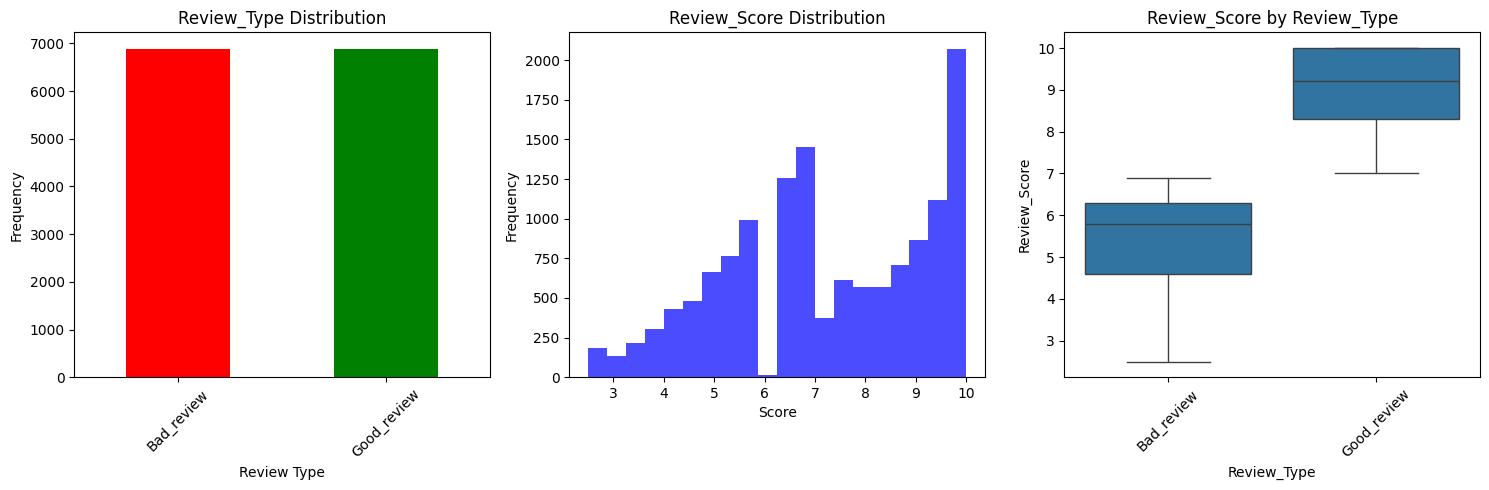

In [12]:
# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Review_Type distribution
df['Review_Type'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Review_Type Distribution')
axes[0].set_xlabel('Review Type')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Review_Score distribution
axes[1].hist(df['Review_Score'], bins=20, alpha=0.7, color='blue')
axes[1].set_title('Review_Score Distribution')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

# Boxplot Review_Score by Review_Type
sns.boxplot(data=df, x='Review_Type', y='Review_Score', ax=axes[2])
axes[2].set_title('Review_Score by Review_Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### **2.b Data Preprocessing**

In [13]:
# 1. Date preprocessing - extract only the year
print("1. Review_Date preprocessing:")
df['Review_Year'] = pd.to_datetime(df['Review_Date']).dt.year
print(f"Available years: {sorted(df['Review_Year'].unique())}")
print(f"Distribution by year:\n{df['Review_Year'].value_counts().sort_index()}")

1. Review_Date preprocessing:
Available years: [np.int32(2015), np.int32(2016), np.int32(2017)]
Distribution by year:
Review_Year
2015    2653
2016    6926
2017    4193
Name: count, dtype: int64


In [14]:
# 2. Target variable encoding for classification
print("2. Encoding Review_Type:")
# Convert to binary format: Good_review = 1, Bad_review = 0
df['Review_Type_Binary'] = (df['Review_Type'] == 'Good_review').astype(int)
print(f"Mapping: Good_review -> 1, Bad_review -> 0")
print(f"Binary distribution:\n{df['Review_Type_Binary'].value_counts()}")

2. Encoding Review_Type:
Mapping: Good_review -> 1, Bad_review -> 0
Binary distribution:
Review_Type_Binary
0    6888
1    6884
Name: count, dtype: int64


**CHANGE:** During text preprocessing, I set any missing review to an empty string. This wasn’t specified in the written plan, but it prevents errors during tokenization and keeps the pipeline robust.


In [15]:
# 3. Preprocessing of review text
print("3. Text preprocessing:")

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Text preprocessing for reviews
    """
    # to avoid problems with missing reviews, I turn NaNs into empty strings.
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = ' '.join(text.split())

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply preprocessing to review text
df['Review_Processed'] = df['Review'].apply(preprocess_text)

# Review length analysis
df['Review_Length'] = df['Review_Processed'].str.split().str.len()
print(f"Average review length: {df['Review_Length'].mean():.1f} words")
print(f"Maximum length: {df['Review_Length'].max()} words")
print(f"Length percentiles: 25%={df['Review_Length'].quantile(0.25):.0f}, "
      f"50%={df['Review_Length'].quantile(0.5):.0f}, "
      f"75%={df['Review_Length'].quantile(0.75):.0f}, "
      f"95%={df['Review_Length'].quantile(0.95):.0f}")

3. Text preprocessing:


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Average review length: 13.8 words
Maximum length: 276 words
Length percentiles: 25%=3, 50%=6, 75%=16, 95%=50


* Creation of the Final Dataset

In [16]:
# 4. Feature selection according to my project

# Create the final dataset with only the required features
# According to my project: 6 total features
df_final = pd.DataFrame({
    'Hotel_Name': df['Hotel_Name'],
    'Review_Year': df['Review_Year'],  # Year extracted from Review_Date
    'Hotel_number_reviews': df['Hotel_number_reviews'],
    'Review_Text': df['Review_Processed'],  # Preprocessed text
    'Review_Score': df['Review_Score'],     # Regression target
    'Review_Type_Binary': df['Review_Type_Binary']  # Classification target (0/1)
})

print(f"Final dataset shape: {df_final.shape}")

Final dataset shape: (13772, 6)


In [17]:
print("Final dataset columns:")
for i, col in enumerate(df_final.columns, 1):
    print(f"{i}. {col}")

Final dataset columns:
1. Hotel_Name
2. Review_Year
3. Hotel_number_reviews
4. Review_Text
5. Review_Score
6. Review_Type_Binary


In [18]:
print(f"Final dataset info:")
df_final.info()

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hotel_Name            13772 non-null  object 
 1   Review_Year           13772 non-null  int32  
 2   Hotel_number_reviews  13772 non-null  int64  
 3   Review_Text           13772 non-null  object 
 4   Review_Score          13772 non-null  float64
 5   Review_Type_Binary    13772 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 591.9+ KB


* Final Checks

In [19]:
# Final check
print(f"Total number of samples: {len(df_final)}")
print(f"Numerical features: Review_Year, Hotel_number_reviews")
print(f"Text features: Hotel_Name, Review_Text")
print(f"Regression target: Review_Score (min={df_final['Review_Score'].min()}, max={df_final['Review_Score'].max()})")
print(f"Classification target: Review_Type_Binary (0={sum(df_final['Review_Type_Binary']==0)}, 1={sum(df_final['Review_Type_Binary']==1)})")

Total number of samples: 13772
Numerical features: Review_Year, Hotel_number_reviews
Text features: Hotel_Name, Review_Text
Regression target: Review_Score (min=2.5, max=10.0)
Classification target: Review_Type_Binary (0=6888, 1=6884)


* Parameters for LSTM

In [20]:
# Sequence length statistics (important for LSTM)
print(f"Average review length: {df['Review_Length'].mean():.1f} words")
print(f"Recommended sequence_length: {int(df['Review_Length'].quantile(0.95))} words (95th percentile)")
print(f"Maximum length found: {df['Review_Length'].max()} words")

# Approximate vocabulary size
all_text = ' '.join(df_final['Review_Text'].astype(str) + ' ' + df_final['Hotel_Name'].astype(str))
vocab_size_approx = len(set(all_text.split()))
print(f"Approximate vocabulary size: {vocab_size_approx} unique words")

Average review length: 13.8 words
Recommended sequence_length: 50 words (95th percentile)
Maximum length found: 276 words
Approximate vocabulary size: 12817 unique words


* Final dataset

In [21]:
print(f"Shape: {df_final.shape}")

Shape: (13772, 6)


In [22]:
df_final.head()

,Hotel_Name,Review_Year,Hotel_number_reviews,Review_Text,Review_Score,Review_Type_Binary
0,Copthorne Tara Hotel London Kensington,2017,7105,expensive room rate include parking breakfast ...,6.7,0
1,BEST WESTERN Maitrise Hotel Maida Vale,2016,1877,bedroom basement windows small room next noisy...,5.8,0
2,Catalonia Ramblas 4 Sup,2016,4276,room ready makeover location,6.3,0
3,Hyatt Regency Paris Etoile,2016,3973,firstly lady check desk quite unfriendly greet...,5.8,0
4,Best Western PLUS Epping Forest,2016,587,able park vehicle due staff filling car park u...,3.3,0


### **2.c Train / Validation / Test Split**

**CHANGE:** In the written exam, I just mentioned splitting the data into train, validation, and test sets, but I didn’t specify how.   
Here, I implemented a two-step stratified split (first 70% train, then the remaining 30% into 15% validation and 15% test). It makes sure both classes are balanced everywhere, so I don't end up with, say, only one class in the validation or test set by accident.

In [23]:
# Split of dataset
X = df_final.drop(['Review_Score', 'Review_Type_Binary'], axis=1)
y_reg = df_final['Review_Score'].values
y_clf = df_final['Review_Type_Binary'].values

X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.5, random_state=42, stratify=y_clf_temp
)

In [24]:
# verify the distribution of classes
print(f"Class Distribution:")
print(f"Train - Bad: {sum(y_clf_train==0)}, Good: {sum(y_clf_train==1)}")
print(f"Val - Bad: {sum(y_clf_val==0)}, Good: {sum(y_clf_val==1)}")
print(f"Test - Bad: {sum(y_clf_test==0)}, Good: {sum(y_clf_test==1)}")

Class Distribution:
Train - Bad: 4821, Good: 4819
Val - Bad: 1033, Good: 1033
Test - Bad: 1034, Good: 1032


**CHANGE:** I standardized `Review_Year` and `Hotel_number_reviews` so they’re on the same scale. Otherwise, the model could just focus on the bigger numbers and ignore the rest.
Moreover, I tokenized the text and set a fixed sequence length at the 95th percentile of actual review lengths. This way, almost all reviews fit, but I’m not wasting time or memory on a handful of really long ones. Here I also joined the `Review_Text` and `Hotel_Name`, so the LSTM can use all the text info together. It can be useful because sometimes the hotel name itself gives context that could influence both the review score and the sentiment. Lastly, I used the `oov_token` parameter in the tokenizer to handle out-of-vocabulary words. This avoids issues when the model encounters words it hasn’t seen during training.



In [25]:
# 1. Full text (Review + Hotel Name)
X_train['combined_text'] = X_train['Review_Text'] + ' ' + X_train['Hotel_Name']
X_val['combined_text'] = X_val['Review_Text'] + ' ' + X_val['Hotel_Name']
X_test['combined_text'] = X_test['Review_Text'] + ' ' + X_test['Hotel_Name']

In [26]:
# Tokenization
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['combined_text'])

X_train_text = pad_sequences(tokenizer.texts_to_sequences(X_train['combined_text']), maxlen=SEQUENCE_LENGTH)
X_val_text = pad_sequences(tokenizer.texts_to_sequences(X_val['combined_text']), maxlen=SEQUENCE_LENGTH)
X_test_text = pad_sequences(tokenizer.texts_to_sequences(X_test['combined_text']), maxlen=SEQUENCE_LENGTH)

# Numerical features
numerical_features = ['Review_Year', 'Hotel_number_reviews']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_val_num = scaler.transform(X_val[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

In [27]:
print(f"Text input shape: {X_train_text.shape}")
print(f"Numerical input shape: {X_train_num.shape}")

Text input shape: (9640, 50)
Numerical input shape: (9640, 2)


## **3. Output and Activation**

For this project, I wanted my model to predict both the review type (binary classification: good/bad) and the review score (regression: a number between 2.5 and 10). To make this happen, I gave my model two different output heads:

- For the classification task, I use a single neuron with a **sigmoid activation**. It’s the standard for binary problems, since it outputs a value between 0 and 1, interpretable as a probability.

- For the regression task, I use a single neuron with a **linear activation**. That just means it can output any real value and it is perfect for predicting the review score, which is continuous.

In this way, the model produces both the probability that a review is positive and the predicted score for each input.



## **4. Loss**
I chose to solve both tasks within the same model, using a combined loss, because this way I can share feature extraction and train a more general representation. Technically, I could have solved them separately as well, but I decided to take this direction during the exam. I thought it could be interesting, even though we hadn’t explicitly covered this method in class.

I combine both losses into a single weighted sum:
- **Binary Cross-Entropy** for the classification output.
- **Mean Squared Error (MSE)** for the regression output.

I assign equal weights (0.5 each) to the two objectives.

This combination also makes the training a bit more challenging, but the code stays clean and the results are easier to compare in one go.

## **5. Model Configuration**

### **5.a Model Architecture**

I decided to use a multitask architecture that predicts both the review type (binary classification) and the review score (regression) in a single model.  
This way, the network can share learned representations between the two tasks, which is often beneficial when both are based on similar features.  
- For text, I use an LSTM branch (ReLU + He initializer) since LSTMs are excellent for sequence modeling and capturing sentiment.
- For numeric inputs, I use a simple MLP with tanh activation and Xavier initialization, which a classic setup for tabular data.
- I concatenate both branches and output through two separate heads: sigmoid for classification and linear for regression.


### **Initializers**

I paid attention to weight initialization, since it can make a difference for convergence speed and stability.

- For layers using ReLU activations (like my LSTM for text), I use **He initialization**. This is pretty much the gold standard for ReLU because it keeps the variance under control as data flows through the network.
- For layers using tanh (like my MLP for numeric features), I use **Xavier (Glorot) initialization**. Xavier is known to work well with tanh and keeps everything nicely scaled from the start.


###**Regularizers**

I use **Dropout** after the main layers in both the text and numeric branches. Dropout helps prevent overfitting, which can be a real issue with relatively small datasets and expressive models.

**CHANGE:** In the written solution, I only mentioned using dropout in general. Here, I specifically applied dropout after the LSTM and Dense layers, choosing standard rates (0.2 or 0.3) based on what usually works well in practice and to make the model more robust without slowing down learning too much.

To keep things simple and reduce the risk of over-regularization, I dind't use batch normalization and L2 regularization.


###**Optimizer**

For optimization, I picked **Adam**, which is particularly used in deep learning projects these days with 0.001 as learning rate.  
Adam combines the advantages of RMSProp and momentum, making it fast to converge and pretty robust to hyperparameter settings.  

In [28]:
# UNIFIED MODEL WITH PROPER INITIALIZATIONS
def create_unified_model():
    """
    Creates the unified model according to the theoretical project specifications
    """
    # Input layers
    text_input = layers.Input(shape=(SEQUENCE_LENGTH,), name='text_input')
    numerical_input = layers.Input(shape=(2,), name='numerical_input')

    # TEXT BRANCH - LSTM FOR CLASSIFICATION
    # Embedding layer
    embedding = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        embeddings_initializer='uniform'  # Default for embedding
    )(text_input)

    # LSTM with ReLU activation and He initialization
    lstm_out = layers.LSTM(
        64,
        return_sequences=False,
        activation='relu',
        kernel_initializer=initializers.HeNormal(),  # He initialization for ReLU
        recurrent_initializer=initializers.HeNormal()
    )(embedding)

    lstm_dropout = layers.Dropout(0.3)(lstm_out)

    # NUMERICAL BRANCH - MLP FOR REGRESSION
    # Dense layers with tanh activation and Xavier/Glorot initialization
    num_dense1 = layers.Dense(
        32,
        activation='tanh',
        kernel_initializer=initializers.GlorotUniform()  # Xavier/Glorot for tanh
    )(numerical_input)

    num_dropout1 = layers.Dropout(0.3)(num_dense1)

    num_dense2 = layers.Dense(
        16,
        activation='tanh',
        kernel_initializer=initializers.GlorotUniform()
    )(num_dropout1)

    # FEATURE CONCATENATION
    combined = layers.Concatenate()([lstm_dropout, num_dense2])

    # OUTPUT FOR CLASSIFICATION (with ReLU as in the project)
    clf_dense = layers.Dense(
        32,
        activation='relu',
        kernel_initializer=initializers.HeNormal()
    )(combined)
    clf_dropout = layers.Dropout(0.2)(clf_dense)

    classification_output = layers.Dense(
        1,
        activation='sigmoid',
        name='classification',
        kernel_initializer=initializers.GlorotUniform()
    )(clf_dropout)

    # OUTPUT FOR REGRESSION (with tanh as in the project)
    reg_dense = layers.Dense(
        32,
        activation='tanh',
        kernel_initializer=initializers.GlorotUniform()
    )(combined)
    reg_dropout = layers.Dropout(0.2)(reg_dense)

    regression_output = layers.Dense(
        1,
        activation='linear',
        name='regression',
        kernel_initializer=initializers.GlorotUniform()
    )(reg_dropout)

    # FINAL MODEL
    model = models.Model(
        inputs=[text_input, numerical_input],
        outputs=[classification_output, regression_output]
    )

    return model

In [29]:
# Import the necessary module for initializers
from tensorflow.keras import initializers

# Creation of the model
model = create_unified_model()

# COMBINED LOSS (λ=0.5, β=0.5)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss={
        'classification': 'binary_crossentropy',  # Binary Cross Entropy
        'regression': 'mse'  # MSE
    },
    loss_weights={
        'classification': 0.5,  # λ = 0.5
        'regression': 0.5       # β = 0.5
    },
    metrics={
        'classification': ['accuracy'],
        'regression': ['mae']
    }
)

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │    320,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         96 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 358,898 (1.37 MB)

 Trainable params: 358,898 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Training**

I train the unified model, tracking both the classification and regression metrics on the validation set.  
I keep the number of epochs and batch size reasonable so that the notebook completes quickly, as required by the exam instructions.


In [31]:
# TRAINING
history = model.fit(
    [X_train_text, X_train_num],
    [y_clf_train, y_reg_train],
    validation_data=([X_val_text, X_val_num], [y_clf_val, y_reg_val]),
    epochs=20,
    batch_size=32,
    verbose=2
)

Epoch 1/20
302/302 - 21s - 68ms/step - classification_accuracy: 0.7129 - classification_loss: 0.7145 - loss: 4.0912 - regression_loss: 7.4660 - regression_mae: 2.0424 - val_classification_accuracy: 0.8606 - val_classification_loss: 0.3461 - val_loss: 1.3634 - val_regression_loss: 2.3809 - val_regression_mae: 1.2131
Epoch 2/20
302/302 - 9s - 31ms/step - classification_accuracy: 0.7087 - classification_loss: 471.2397 - loss: 238.4098 - regression_loss: 4.3989 - regression_mae: 1.6455 - val_classification_accuracy: 0.8708 - val_classification_loss: 0.4181 - val_loss: 1.2405 - val_regression_loss: 2.0652 - val_regression_mae: 1.1050
Epoch 3/20
302/302 - 11s - 37ms/step - classification_accuracy: 0.8618 - classification_loss: 0.3945 - loss: 1.4341 - regression_loss: 2.4716 - regression_mae: 1.2272 - val_classification_accuracy: 0.8761 - val_classification_loss: 0.3254 - val_loss: 1.0745 - val_regression_loss: 1.8248 - val_regression_mae: 1.0651
Epoch 4/20
302/302 - 20s - 66ms/step - classif

### **5.b Hyperparameter Tuning**

We always trained and tuned models for single tasks only: either classification or regression, but never both at the same time. My code is more complex because I implemented a multitask model with two outputs (binary classification and regression) and a combined total loss. This was not explicited covered in university labs but I wanted to try it.

**CHANGE:**
During the exam, I only chose which hyperparameters to tune, without specifying the method. During the implementation, I decided to use **random search** for hyperparameter tuning because, in my opinion, with a multitask model, a full grid search would be computationally excessive. For this reason, I figured it’s better to explore more of the space randomly than to overfit on a small grid. I set random seeds for both NumPy and TensorFlow to make the runs reproducible, so results are consistent if I re-run the notebook. Moreover, I divided the MSE by 10 when computing the combined score in the random search.  
Otherwise, the scale of MSE and accuracy would be too different and one could easily overpower the other when choosing the best params.

### **Hyperparameters**

The main hyperparameters I considered:
- Learning rate
- Number of LSTM and Dense units
- Dropout rate (regularization strength)
- Batch size and number of epochs
- Sequence length for text input (tuned based on review length percentiles)

**CHANGE:** While I listed sequence length as a hyperparameter, in practice I did not tune it via random search. Instead, I fixed it at 50 words (the 95th percentile of actual review lengths) after exploring the data distribution. Tuning this parameter would mostly increase computation time for very little practical benefit, since nearly all reviews are way shorter than the max.


For each experiment, I made sure to keep the validation split balanced and checked the results on both classification and regression metrics. Again, my focus was on building a fair, not necessarily optimal, model, given the time and resource constraints.


In [32]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Simplified hyperparameter space
param_dist = {
    'learning_rate': [0.001, 0.0005],
    'lstm_units': [64, 128],
    'dense_units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [15, 20]
}

# Number of random combinations to try
n_iter = 5

In [33]:
# Function to create unified model
def create_model(params):
    # Input layers
    text_input = layers.Input(shape=(50,), name='text_input')
    numerical_input = layers.Input(shape=(2,), name='numerical_input')

    # Text branch
    embedding = layers.Embedding(5000, 64)(text_input)
    lstm = layers.LSTM(params['lstm_units'])(embedding)
    text_output = layers.Dropout(params['dropout_rate'])(lstm)

    # Numerical branch
    num_dense = layers.Dense(params['dense_units'], activation='tanh')(numerical_input)
    num_output = layers.Dropout(params['dropout_rate']/2)(num_dense)

    # Combined
    combined = layers.Concatenate()([text_output, num_output])

    # Outputs
    clf_output = layers.Dense(1, activation='sigmoid', name='classification')(combined)
    reg_output = layers.Dense(1, activation='linear', name='regression')(combined)

    # Model
    model = models.Model(
        inputs=[text_input, numerical_input],
        outputs=[clf_output, reg_output]
    )

    model.compile(
        optimizer=optimizers.Adam(params['learning_rate']),
        loss={
            'classification': 'binary_crossentropy',
            'regression': 'mse'
        },
        metrics={
            'classification': 'accuracy',
            'regression': 'mse'
        }
    )
    return model

In [34]:
# Random parameter sampling
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# Store results
results = []

for params in param_list:
    print(f"\nTesting params: {params}")

    model = create_model(params)

    history = model.fit(
        [X_train_text, X_train_num],
        [y_clf_train, y_reg_train],
        validation_data=([X_val_text, X_val_num], [y_clf_val, y_reg_val]),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    # Evaluate
    y_pred_clf, y_pred_reg = model.predict([X_val_text, X_val_num])
    y_pred_clf = (y_pred_clf > 0.5).astype(int)

    clf_acc = accuracy_score(y_clf_val, y_pred_clf)
    reg_mse = mean_squared_error(y_reg_val, y_pred_reg)

    # Combined score (higher is better)
    combined_score = clf_acc - (reg_mse / 10)  # Normalize MSE

    results.append({
        'params': params,
        'clf_accuracy': clf_acc,
        'reg_mse': reg_mse,
        'combined_score': combined_score
    })

    print(f"Val Accuracy: {clf_acc:.4f}, Val MSE: {reg_mse:.4f}, Combined: {combined_score:.4f}")

# Get best parameters
best_result = max(results, key=lambda x: x['combined_score'])
best_params = best_result['params']

print("\nBest Parameters Found:")
print(best_params)


Testing params: {'lstm_units': 64, 'learning_rate': 0.001, 'epochs': 20, 'dropout_rate': 0.2, 'dense_units': 64, 'batch_size': 64}
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Val Accuracy: 0.8790, Val MSE: 1.9341, Combined: 0.6856

Testing params: {'lstm_units': 64, 'learning_rate': 0.0005, 'epochs': 15, 'dropout_rate': 0.3, 'dense_units': 64, 'batch_size': 64}
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Val Accuracy: 0.8921, Val MSE: 1.8439, Combined: 0.7077

Testing params: {'lstm_units': 64, 'learning_rate': 0.001, 'epochs': 15, 'dropout_rate': 0.2, 'dense_units': 32, 'batch_size': 32}
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Val Accuracy: 0.8795, Val MSE: 2.0284, Combined: 0.6766

Testing params: {'lstm_units': 64, 'learning_rate': 0.001, 'epochs': 20, 'dropout_rate': 0.3, 'dense_units': 32, 'batch_size': 64}
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Val Accuracy: 0.8814, Val MSE: 2.0017, Combined: 0.6812

Testing params: {'lstm_units': 128, 'learning_rate': 0.001, 'epochs': 20, 'dropout_rat

In [35]:
# Train final model with best parameters
print("Training final model with best parameters...")
final_model = create_model(best_params)

history = final_model.fit(
    [X_train_text, X_train_num],
    [y_clf_train, y_reg_train],
    validation_data=([X_val_text, X_val_num], [y_clf_val, y_reg_val]),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

Training final model with best parameters...
Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - classification_accuracy: 0.5066 - classification_loss: 0.7114 - loss: 28.8553 - regression_loss: 28.1436 - regression_mse: 28.1439 - val_classification_accuracy: 0.5329 - val_classification_loss: 0.6898 - val_loss: 4.8896 - val_regression_loss: 4.2049 - val_regression_mse: 4.2001
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - classification_accuracy: 0.5102 - classification_loss: 0.7195 - loss: 5.2959 - regression_loss: 4.5764 - regression_mse: 4.5764 - val_classification_accuracy: 0.7043 - val_classification_loss: 0.6511 - val_loss: 3.6626 - val_regression_loss: 3.0109 - val_regression_mse: 3.0119
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - classification_accuracy: 0.7158 - classification_loss: 0.5761 - loss: 3.6148 - regression_loss: 3.0387 - regression_mse: 3.0387 - val_classification_accuracy: 0.8693 - val_classification_loss: 0.3910 - val_loss: 2.5977 - val_regr

## **6. Final Model Evaluation**

I report all relevant metrics on the test set:  
- For classification: accuracy and F1 score, since the classes are already balanced (so precision/recall isn’t strictly necessary).
- For regression: MSE, MAE, and R^2 score, to provide a full picture of numerical prediction performance.
This step is key to check if the model actually generalizes well beyond the training data.


In [36]:
# Evaluate on test set
print("Final Evaluation on Test Set:")
y_pred_clf, y_pred_reg = final_model.predict([X_test_text, X_test_num])
y_pred_clf = (y_pred_clf > 0.5).astype(int)

# Classification metrics
clf_acc = accuracy_score(y_clf_test, y_pred_clf)
clf_f1 = f1_score(y_clf_test, y_pred_clf)

# Regression metrics
reg_mse = mean_squared_error(y_reg_test, y_pred_reg)
reg_mae = mean_absolute_error(y_reg_test, y_pred_reg)
reg_r2 = r2_score(y_reg_test, y_pred_reg)

print(f"\nClassification Metrics:")
print(f"Accuracy: {clf_acc:.4f}")
print(f"F1 Score: {clf_f1:.4f}")

print(f"\nRegression Metrics:")
print(f"MSE: {reg_mse:.4f}")
print(f"MAE: {reg_mae:.4f}")
print(f"R2: {reg_r2:.4f}")

Final Evaluation on Test Set:
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Metrics:
Accuracy: 0.8892
F1 Score: 0.8900

Regression Metrics:
MSE: 1.7637
MAE: 0.9910
R2: 0.5815


### Confusion Matrix

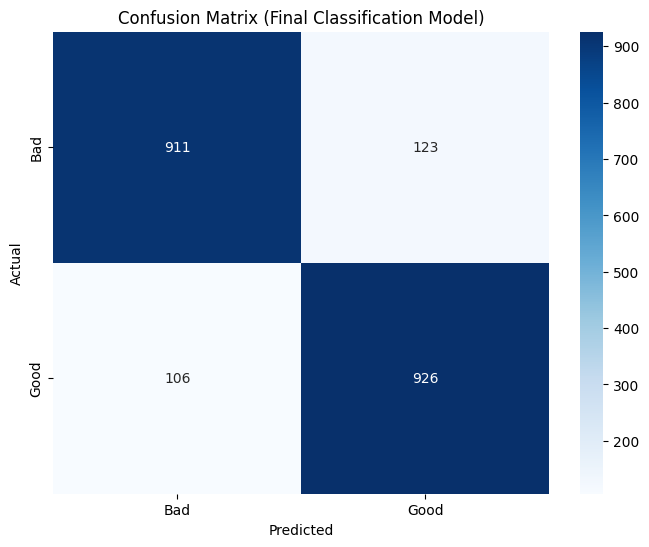

In [37]:
# Calculate confusion matrix for classification
cm_clf = confusion_matrix(y_clf_test, y_pred_clf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_clf, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title('Confusion Matrix (Final Classification Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **7. Final Consideration**

While the results achieved by this multitask model are decent, they are not exceptional, and there are several limitations to keep in mind when interpreting these outcomes.

First of all, the model was trained and tested on the full dataset provided (about 13,700 rows), which is a reasonable size, but the features used and the preprocessing applied were quite simple. More complex feature engineering or richer representations (e.g., pretrained embeddings) might have improved performance, especially for the regression task.

On the classification task, the accuracy and F1 score were around 0.88–0.89, which is fair but still leaves plenty of room for improvement. For the regression task, an R^2 of 0.57 and an MAE of around 1.0 indicate that the model can follow the general trend of the scores but fails to capture much of the finer variability.

There are also architectural choices that could be improved. I relied on basic text cleaning, a simple LSTM, and relatively shallow dense layers. Currently, more advanced NLP models (e.g., transformer-based architectures) or even just better embeddings could capture far more nuanced patterns in the reviews.

Another important factor is that hyperparameter tuning was done using random search and with limited compute, rather than a full grid search or more advanced optimization strategies. This means the best possible configuration may not have been found.

Lastly, the multitask approach with joint loss was an experiment on my part. While it allowed the model to share some knowledge between the tasks, it may have limited the maximum achievable performance for each task individually. With more time and resources, I would consider separate models, try ensembling, or even add external data to improve results.

In summary, the results are reasonable for an initial, resource-limited attempt, but there’s a lot of room for improvement. Better text representations, more careful model selection, deeper tuning, and perhaps larger or more diverse data could all help push the results to a higher level.
